In [1]:
import pymc as pm, polars as pl
import matplotlib.pyplot as plt, numpy as np, xarray as xr
import arviz as az

In [2]:
d = pl.read_csv("../../Rethinking_2/Data/Howell1.csv", separator=";")
df_young = d.select("height", "weight").with_columns(weight_squared=pl.col("weight")**2)

array([[<Axes: ylabel='height'>, <Axes: >],
       [<Axes: xlabel='weight', ylabel='weight_squared'>,
        <Axes: xlabel='height'>]], dtype=object)

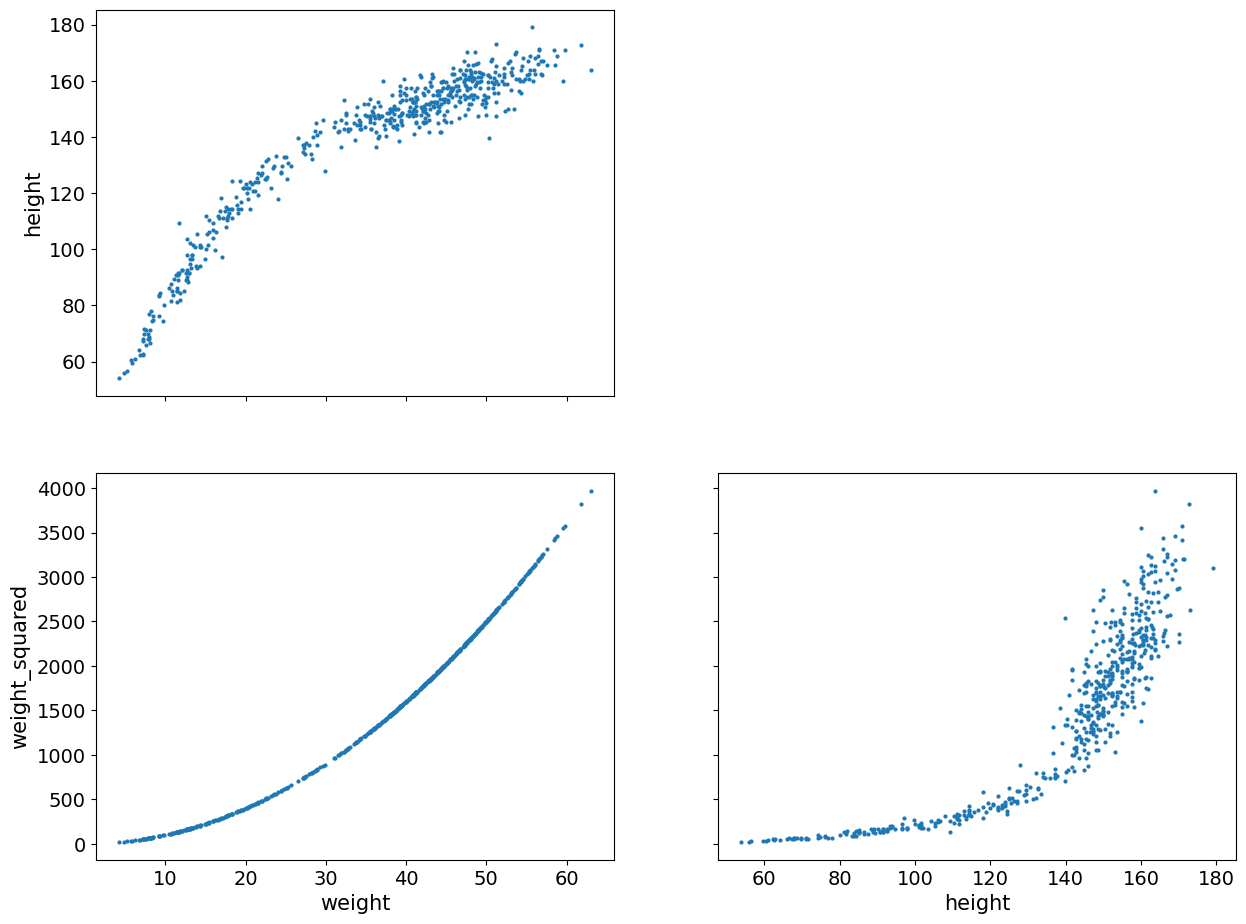

In [3]:
az.plot_pair(df_young.to_dict(), var_names=["weight", "height", "weight_squared"])

In [43]:
# model definition
with pm.Model() as basic_model:
    # priors
    alpha = pm.Normal(name="alpha", mu=50, sigma=20)
    beta_1 = pm.Normal(name="beta_1", mu=2, sigma=1)
    beta_2 = pm.Normal(name="beta_2", mu=0, sigma=0.01)
    sigma = pm.Uniform(name="sigma", lower=0, upper=50)

    mu = alpha + beta_1*df_young["weight"].to_numpy() + beta_2*df_young["weight_squared"].to_numpy()

    height = pm.Normal("height", mu=mu, sigma=sigma, observed=df_young["height"].to_numpy())

    # check prior predictive
    idata = pm.sample_prior_predictive(draws=100)

Sampling: [alpha, beta_1, beta_2, height, sigma]


In [44]:
idata

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

Text(0.5, 1.0, 'Prior predictive checks -- Weakly regularizing priors')

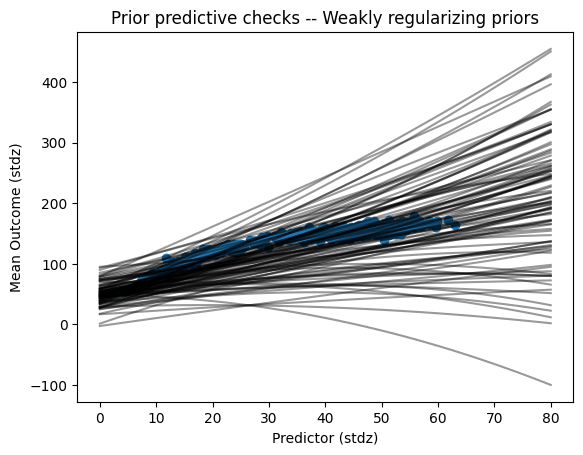

In [45]:
_, ax = plt.subplots()

x = xr.DataArray(np.linspace(0, 80, 70), dims=["plot_dim"])
prior = idata.prior
y = prior["alpha"] + prior["beta_1"] * x + prior["beta_2"] * x**2

ax.plot(x, y.stack(sample=("chain", "draw")), c="k", alpha=0.4)
ax.scatter(df_young["weight"].to_numpy(), df_young["height"].to_numpy())

ax.set_xlabel("Predictor (stdz)")
ax.set_ylabel("Mean Outcome (stdz)")
ax.set_title("Prior predictive checks -- Weakly regularizing priors")

In [46]:
with basic_model:
    idata_posterior = pm.sample(draws=1000)

idata_posterior

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_1, beta_2, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta_1'}>,
        <Axes: title={'center': 'beta_1'}>],
       [<Axes: title={'center': 'beta_2'}>,
        <Axes: title={'center': 'beta_2'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

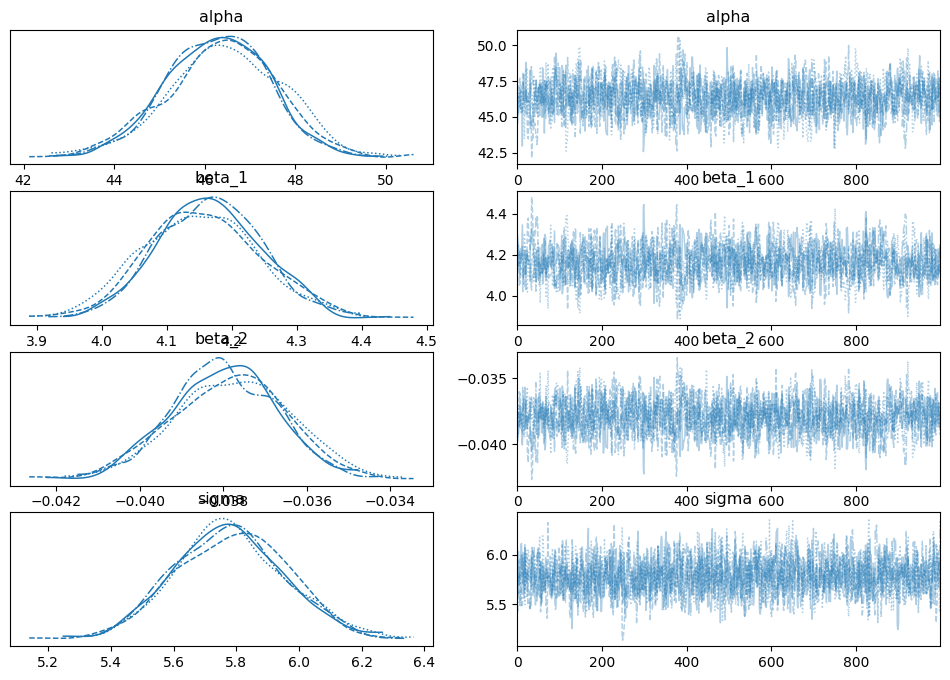

In [47]:
az.plot_trace(idata_posterior["posterior"])

In [48]:
with basic_model:
    pm.sample_posterior_predictive(idata_posterior, extend_inferencedata=True)

Sampling: [height]


Output()

In [49]:
idata_posterior

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

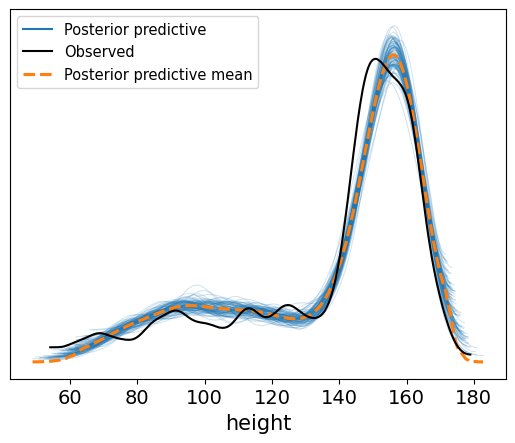

In [50]:
az.plot_ppc(idata_posterior, num_pp_samples=100,);

In [52]:
post = idata_posterior.posterior
mu_pp = post["alpha"] + post["beta_1"] * xr.DataArray(df_young["weight"].to_numpy(), dims=["obs_id"]) +  post["beta_2"] * xr.DataArray(df_young["weight"].to_numpy(), dims=["obs_id"])**2

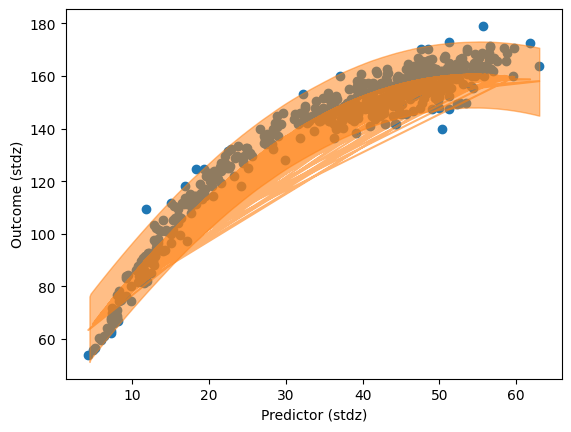

In [53]:
_, ax = plt.subplots()

ax.plot(
    df_young["weight"].to_numpy(), mu_pp.mean(("chain", "draw")), label="Mean outcome", color="C1", alpha=0.6
)
ax.scatter(df_young["weight"].to_numpy(), idata_posterior.observed_data["height"])
az.plot_hdi(df_young["weight"].to_numpy(), idata_posterior.posterior_predictive["height"], hdi_prob=0.97)

ax.set_xlabel("Predictor (stdz)")
ax.set_ylabel("Outcome (stdz)");